# Two Stream Instability PIC  Simulation

### What is PIC?
Particle-In-Cell or Particle-Mesh is a computational method that relies on calculating electron densities, electric potentials and electric fields on a mesh. It is preferred in plasma physics simulations because of its ability to deal with systems that have a lot of particles. 

#### How does a PIC simulation work?
We can split the PIC method into 4 smaller parts:
1) Integration of equations of motion with an integration method of choice(Velocity-Verlet in our case).   
2) Weighting(will be explained further later on).   
3) Integration of field equations on a grid.   
4) Weighting(will be explained further later on).   
All of these happen every time step Δt.

### What is a "two stream instability"?
Two stream instability is an example of wave growth which occurs in the case of two oppositely directed electron beams, which is the case we are studying right now(there are more cases which we can observe this effect).
<br>
<br>
Two stream instability is the phenomenon of exponentially growing oscillations in said two streams in relative motion which produces strong spatial inhomogeneities, causing the electrons to clump together and dissipate energy of the electron beams into plasma waves.

### Time For The Simulation!

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

In [10]:
# Definition of simulation parameters.

# Number of particles.
N_part = 40000
# Number of mesh cells.
N_mesh = 400
# Simulation duration.
t = 50
# Time step.
dt = 0.5
# Size of the periodic box.
box_size = 50
# Size of each cell.
dx = box_size / N_mesh
# Electron number density.
n_0 = 1
# Velocity constant for the Gaussian beams.
b_vel = 3
# Width constant for the Gaussian beams.
b_wd = 1
# Perturbation.
P = 0.1

In [11]:
# Definition of the initial conditions.

# Seed for the random number generator, in case we need to replicate our results.
np.random.seed(42)


# Create two Gaussian beams (consisting of electrons) moving opposite to each other.

#The np.random.rand(R, C) is used to create a RxC matrix consisting of random numbers in range 0 and 1.
# Define a Nx1 random matrix for ALL particle positions.
pos_part = np.random.rand(N_part, 1) * box_size
# Define a Nx1 random matrix for ALL particle velocities.
vel_part = b_wd * np.random.randn(N_part, 1) + b_vel
# Number of particles of each beam.
N_b = int(N_part/2)
# Revert the sign of half of the particle velocities, thus creating two beams opposite to each other.
vel_part[N_b:] *= -1
# Add perturbation to particle velocities.
vel_part *= (1 + P*np.sin(2*np.pi*pos_part/box_size))

### Gradient and Laplacian Calculations With Matrix Representations
In order to compute the Gradient and Laplacian, we need to perform numerical differentiation. 
***
For the gradient calculation, I will be using the "first order central difference method"; which is $ y'(x) ≈ (y(x + ∆x) - y(x - ∆x)) / 2∆x $.
***
For the Laplacian calculation, I will be using the "second order central difference method"; which is $ y''(x) ≈ (y(x + ∆x) - 2y(x) + y(x - ∆x)) / ∆x^2 $.
***
I can iterate over all the points we just defined and carry out the differentiation one by one, however I will use a different approach which I have just found out. Matrix representation! 
***
Matrix representation of the first order central difference method is
$$ 
\begin{pmatrix}
y'_1 \\ y'_2 \\ ... \\ y'_N 
\end{pmatrix}
≈ (1 / 2∆x) 
\begin{pmatrix}
-1 & 0 & 1 & ...\\ ... & ... & ... & ... \\ ... & ... & ... & ... \\ ... & -1 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
y_0 \\ y_1 \\ ... \\ y_N+_1
\end{pmatrix}
$$

Matrix representation of the second order central difference method is
$$ 
\begin{pmatrix}
y''_1 \\ y''_2 \\ ... \\ y''_N 
\end{pmatrix}
≈ (1 / ∆x^2) 
\begin{pmatrix}
1 & -2 & 1 & ...\\ ... & ... & ... & ... \\ ... & ... & ... & ... \\ ... & 1 & -2 & 1
\end{pmatrix}
\begin{pmatrix}
y_0 \\ y_1 \\ ... \\ y_N+_1
\end{pmatrix}
$$
which honestly just blew my mind!
***
Python is really good in terms of its readibility but it suffers in the speed department for sure... Iterating over each element in a simulation is never a good choice, matrix operations carried out by the "Numpy" module will always be faster! Therefore, this matrix representation will allow us to use matrix operations instead of loop iterations!   
   
The cells dedicated to the laplacian and gradient matrices will give more context about this method.

### Electric Field Calculation With Gradient Matrix.
For the electric field calculation, we need to solve the negative gradient of the electric potential (we can substitute gradient by a ordinary derivative since we are only solving for one dimension):
$$ E(x) = - \frac{dϕ}{dx} ≈ - \frac{ϕ_{j+1} - ϕ_{j-1}}{2Δx}$$
Which can be solved using the matrix method described above as:
$$
\begin{pmatrix}
E_1 \\ E_2 \\ E_3 \\  ... \\ E_{m - 1} \\ E_m
\end{pmatrix}
= 
- \frac{1}{2Δx}
\begin{pmatrix}
0 & -1 & ... & ... & ... & 1 \\ 1 & 0 & 1 & ... & ... & ...\\ ... & 1 & 0 & 1 & ... & ... \\ ... & ... & ... & ... & ... & ...\\ ... & ... & ... & 1 & 0 & 1 \\  1 & ... & ... & ... & 1 & 0 
\end{pmatrix}
\begin{pmatrix}
ϕ_1 \\ ϕ_2 \\ ϕ_3 \\  ... \\ ϕ_{m - 1} \\ ϕ_m
\end{pmatrix}
$$
The code cell below constructs the gradient matrix for us to carry out the calculation later on during the acceleration calculations.

In [12]:
# Construct matrix G to compute the Gradient (1st derivative)
e = np.ones(N_mesh)
diags = np.array([-1,1])
vals  = np.vstack((-e,e))
Gmtx = sp.spdiags(vals, diags, N_mesh, N_mesh)
Gmtx = sp.lil_matrix(Gmtx)
Gmtx[0,N_mesh-1] = -1
Gmtx[N_mesh-1,0] = 1
Gmtx /= (2*dx)
Gmtx = sp.csr_matrix(Gmtx)

### Electric Potential Calculation With Laplacian Matrix.
For the electric potential calculation, we need to solve Poisson's equation:
$$ \frac{d^2ϕ(x_j)}{dx^2} ≈ \frac{(ϕ_{j-1} + ϕ_{j+1} - 2ϕ_j)}{(Δx)^2} = n - n_0$$
Which can be solved using the matrix method described above as:
$$
\frac{1}{(Δx)^2}
\begin{pmatrix}
-2 & 1 & ... & ... & ... & 1 \\ 1 & -2 & 1 & ... & ... & ...\\ ... & 1 & -2 & 1 & ... & ... \\ ... & ... & ... & ... & ... & ...\\ ... & ... & ... & 1 & -2 & 1 \\  1 & ... & ... & ... & 1 & -2 
\end{pmatrix}
\begin{pmatrix}
ϕ_1 \\ ϕ_2 \\ ϕ_3 \\  ... \\ ϕ_{m - 1} \\ ϕ_m
\end{pmatrix}
=
\begin{pmatrix}
n_1 \\ n_2 \\ n_3 \\  ... \\ n_{m - 1} \\ n_m
\end{pmatrix}
- n_0
$$
The code cell below constructs the laplacian matrix for us to carry out the calculation later on during the acceleration calculations.

In [13]:
# Construct matrix L to computer Laplacian (2nd derivative)
diags = np.array([-1,0,1])
vals  = np.vstack((e,-2*e,e))
Lmtx = sp.spdiags(vals, diags, N_mesh, N_mesh);
Lmtx = sp.lil_matrix(Lmtx)
Lmtx[0,N_mesh-1] = 1
Lmtx[N_mesh-1,0] = 1
Lmtx /= dx**2
Lmtx = sp.csr_matrix(Lmtx)

### Cloud In Cell Weighting Method
Wherever the individual particles in a simulation may be, the quantities like the number density and fields are only calculated on the mesh points. To understand the weighting process, it may be the best to inspect the following figures demonstrating the cloud in cell weighting method. 
<img src="cloudincell.png" width="400" height="200">
<br>
This method can be applied by:
$$ q_j = q_i * [\frac{Δx - (x_i - x_j)}{Δx} = q_i * \frac{x_{j+1} - x_i}{Δx}]$$
$$ q_{j+1} = q_i * \frac{x_i - x_j}{Δx}$$

In [14]:
def calcAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx ):
    N = pos.shape[0]
    dx = boxsize / Nx
    
    # Cloud In Cell weighting method used here.
    j = np.floor(pos/dx).astype(int)
    jp1 = j+1
    weight_j = (jp1 * dx - pos) / dx
    weight_jp1 = (pos - j * dx) / dx
    
    # Assertion of the boundary condition, essentially tying the beginning and end points of the simulation together.
    jp1 = np.mod(jp1, Nx)
    
    # Electron number density calculation by placing particles into the 2 nearest bins and normalizing.
    n  = np.bincount(j[:,0],   weights=weight_j[:,0],   minlength=Nx);
    n += np.bincount(jp1[:,0], weights=weight_jp1[:,0], minlength=Nx);
    n *= n0 * boxsize / N / dx 

    # Solve Poisson's Equation, ∇^2(ϕ) = (n-n0).
    phi_grid = spsolve(Lmtx, n-n0, permc_spec="MMD_AT_PLUS_A")
    
    # E = - ∇ϕ. The @ operator is used for matrix multiplication.
    E_grid = - Gmtx @ phi_grid
    
    # Complete the cloud in cell method by interpolating grid value onto particle locations.
    E = weight_j * E_grid[j] + weight_jp1 * E_grid[jp1]
    
    a = -E

    return a

### Integration And The Result

### Velocity Verlet Integration Method
Verlet integration is a method that can be used to integrate equations of motion. The algorithm goes like this(acceleration calculation at step 3):  
1) $$ v(t + 1/2(Δt)) = v(t) + 1/2(a(t) * Δt)$$
2) $$ x(t + Δt) = x(t) + (v(t + 1/2(Δt)) * Δt)$$
3) $$a(t + Δt)$$
4) $$ v(t + Δt) = v(t) + 1/2(a(t) + a(t + Δt))$$

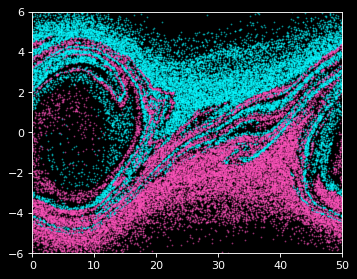

In [15]:
# Calculate the acceleration values to integrate in the main loop.
acc_part = calcAcc(pos_part, N_mesh, box_size, n_0, Gmtx, Lmtx)

# Prepare the figure for plotting later on.

# Dark background for the figure to make it look like space :)))
plt.style.use('dark_background') 
# Generate the figure and axes.
fig = plt.figure(figsize=(5, 4), dpi=80)
ax = fig.add_subplot(111)

# Simulation Main Loop
for i in range(int(t/dt)):
    # First velocity update of the Velocity-Verlet method.
    vel_part += acc_part * dt/2.0
    
    # Update position using the velocity.
    pos_part += vel_part * dt
    # Impose the boundary conditions.
    pos_part = np.mod(pos_part, box_size)
    
    # Update acceleration l
    acc_part = calcAcc(pos_part, N_mesh, box_size, n_0, Gmtx, Lmtx)
    
    # Second velocity update of the Velocity-Verlet method.
    vel_part += acc_part * dt/2.0
    
    # plot in real time - color 1/2 particles blue, other half red
    ax.cla()
    ax.scatter(pos_part[0:N_b],vel_part[0:N_b],s=.4,color='#08F7FE', alpha=0.5)
    ax.scatter(pos_part[N_b:], vel_part[N_b:], s=.4,color='#FE53BB',  alpha=0.5)
    ax.axis([0,box_size,-6,6])
    display(fig)
    
    clear_output(wait = True)